In [1]:
from platform import python_version

print(python_version())

3.9.2


In [2]:
import os
import shutil
import tempfile
import time
import glob
#import opensimplex

from torch.utils.tensorboard import SummaryWriter
#from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
import torch.nn.functional as F
import monai.data
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism
from monai.data.utils import pad_list_data_collate
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import random

import nibabel as nib

from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler

import pandas as pd

from monai.metrics import compute_iou

#print_config()

/bettik/PROJECTS/pr-gin5_aini/fehrdelt/environments/ddpm_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DEVICE_TYPE = "cuda:0"

In [4]:
torch.cuda.current_device()


0

In [5]:
cuda_available = torch.cuda.is_available()
print(f"CUDA is available: {cuda_available}")

CUDA is available: True


In [6]:
#ROOT_DIR = "/home/fehrdelt/bettik/"
ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"

In [7]:
set_determinism(0)

## Setup Dallas Healthy Lifespan ADC Dataset and training and validation dataloaders

2D 128x128 slices of 3D ADC volumes

In [8]:
IMAGE_SIZE = 128

In [9]:
train_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/train.csv")
train_images_path = []

with open(train_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):
        #print(line)
        train_images_path.append(ROOT_DIR+line[0])

val_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/val.csv")
val_images_path = []

with open(val_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        val_images_path.append(ROOT_DIR+line[0])

test_reconstruction_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/test.csv")
test_reconstruction_images_path = []

with open(test_reconstruction_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        test_reconstruction_images_path.append(ROOT_DIR+line[0])


1572it [00:00, 255322.41it/s]
197it [00:00, 114776.76it/s]
197it [00:00, 105352.27it/s]


In [10]:
#train_datalist = sorted(train_images_path)
train_datalist = train_images_path

#val_datalist = sorted(val_images_path)
val_datalist = val_images_path

#val_datalist = sorted(val_images_path)
test_reconstruction_datalist = test_reconstruction_images_path

#test_unhealthy_datalist = test_unhealthy_images_path

batch_size = 32
num_workers = 4


In [11]:
train_datalist[0]

'/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/ADC_Human_Connectome_Project_Young_Adult_HCP-YA_resized128/205119.nii.gz'

In [12]:
class Get2DSlice(transforms.Transform):
    """
    Fetch the middle slice of a 3D volume.
    Args:
        axis: The axis along which to slice the volume. 0 for axial, 1 for coronal, 2 for sagittal.
        offset : Offset the index by a specified amount (default=0)
    """

    def __init__(
        self,
        axis: int = 0,
        offset: int=0
    ):
        super().__init__()
        self.axis = axis
        self.offset = offset

    def __call__(self, data):
        #print(data.shape)
        if self.axis==0:
            return data[:, data.shape[1]//2+self.offset,:,:]
        elif self.axis==1:
            return data[:, :,data.shape[2]//2+self.offset,:]
        elif self.axis==2:
            return data[:, :, :,data.shape[3]//2+self.offset]

In [13]:
class Get2DSliceWithRandomOffset(transforms.RandomizableTransform):
    """
    Will return the middle slice with a random offset in addition to the specified fixed offset.
    Args:
        axis: The axis along which to slice the volume. 0 for axial, 1 for coronal, 2 for sagittal.
        offset : Offset the index by a specified amount (default=0)
    """

    def __init__(
        self,
        axis: int = 0,
        fixed_offset: int=0
    ):
        super().__init__()
        self.axis = axis
        self.fixed_offset = fixed_offset
        self.rand_offset = 0


    def randomize(self):
        super().randomize(None)
        self.rand_offset = random.randint(-1, 1)

    def __call__(self, data):
        #print(data.shape)
        self.randomize()

        #print(self.rand_offset)
        if self.axis==0:
            return data[:, data.shape[1]//2+self.fixed_offset+self.rand_offset,:,:]
        elif self.axis==1:
            return data[:, :,data.shape[2]//2+self.fixed_offset+self.rand_offset,:]
        elif self.axis==2:
            return data[:, :, :,data.shape[3]//2+self.fixed_offset+self.rand_offset]

In [14]:
print(train_datalist[1])

/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Dallas_ADC_rotated_resampled_registered/sub-3727_ses-wave1_ADC.nii.gz


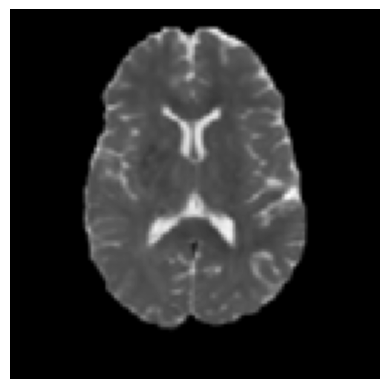

In [15]:
import numpy as np

img = nib.load(train_datalist[0])
import matplotlib.pyplot as plt

img_data = img.get_fdata()
middle_slice = img_data[:, :, img_data.shape[2] // 2]

plt.imshow(middle_slice, cmap="gray")
plt.axis("off")
plt.show()

In [16]:
img = transforms.LoadImage(image_only=True)(train_datalist[0])

In [17]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImage(image_only=True),
        transforms.EnsureChannelFirst(),
        transforms.RandAffine(prob=0.2, rotate_range=(0.15, 0.15, 0.15)),#+- 0.15 radians for each axis
        Get2DSliceWithRandomOffset(axis=2, fixed_offset=0), #28
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandScaleCrop(roi_scale=0.9, max_roi_scale=1.1, random_size=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms) #TODO datalist[:32]
train_loader = DataLoader(
    #collate_fn=pad_list_data_collate: any tensors are centrally padded to match the shape of the biggest tensor in each dimension
    train_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True, collate_fn=pad_list_data_collate
)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1572/1572 [01:18<00:00, 19.96it/s]


In [18]:

val_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2, offset=0),  # 28
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:09<00:00, 20.61it/s]


In [19]:
test_reconstruction_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2, offset=0),
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
test_reconstruction_ds = CacheDataset(data=test_reconstruction_datalist, transform=test_reconstruction_transforms)
test_reconstruction_loader = DataLoader(
    test_reconstruction_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:09<00:00, 20.67it/s]


batch shape: torch.Size([32, 1, 128, 128])


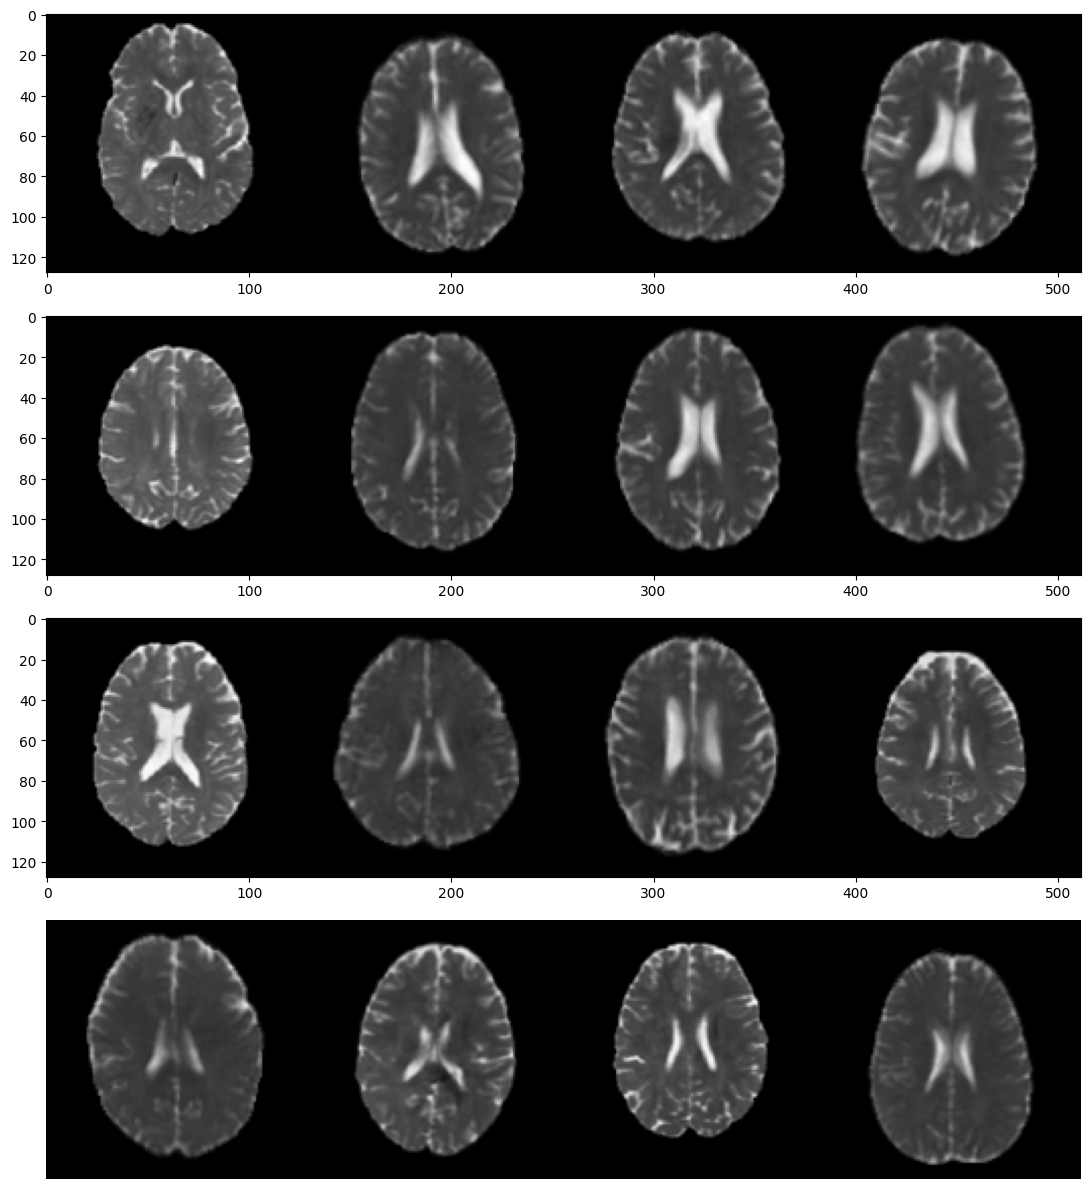

In [20]:

for i, batch in enumerate(train_loader):
    #print(i)
    if i==0:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
    break


### Opensimplex noise 

https://code.larus.se/lmas/opensimplex 

https://pypi.org/project/opensimplex/

https://github.com/Julian-Wyatt/AnoDDPM/blob/master/simplex.py#L212

https://openaccess.thecvf.com/content/CVPR2022W/NTIRE/papers/Wyatt_AnoDDPM_Anomaly_Detection_With_Denoising_Diffusion_Probabilistic_Models_Using_Simplex_CVPRW_2022_paper.pdf

AnoDDPM:

Instead of using the default simplex noise function, we
can apply a number of octaves of noise (also known as frac-
tal noise). This involves combining N frequencies of noise
together, where the next frequency’s amplitude reduces by
some decay rate γ. Figure 2b shows that low frequency
noise cannot be well approximated with a Gaussian distri-
bution; however, by applying an increasing number of oc-
taves of noise, the distribution becomes closer to a Gaussian
distribution. This is paramount for our DDPM model as we
assume our noising function is sampling from a Gaussian
distribution. Therefore, unless stated otherwise, we use a
starting frequency of ν = 2^6 (et pas 2^(-6) comme écrit dans l'article), octave of N = 6 and a de-
cay of γ = 0.8. Furthermore, when generating the simplex
noise, we shuffle the seed before every noise calculation,
and take a slice t from the 3-dimensional noise function,
as we found that artefacts were introduced when sampling
from the 2-dimensional noise function

"""
            Returns a layered fractal noise in 2D\
        :param shape: Shape of 2D tensor output\
        :param octaves: Number of levels of fractal noise\
        :param persistence: float between (0-1) -> Rate at which amplitude of each level decreases\
        :param frequency: Frequency of initial octave of noise\
        :return: Fractal noise sample with n lots of 2D images
        """

! need to do `pip install simplex`

In [21]:
import AnoDDPM.simplex as simplex

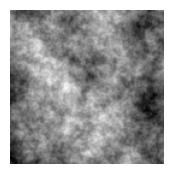

In [22]:
simplexObj = simplex.Simplex_CLASS()
simplexObj.newSeed()
# take a slice t from the 3-dimensional noise function as we found that artefacts 
# were introduced when sampling from the 2-dimensional noise function
simplex_noise = simplexObj.rand_3d_octaves(shape=(128,128, 128), octaves=6, persistence=0.8, frequency=64)[12,...]
plt.figure(figsize=(2, 2))
plt.imshow(simplex_noise, cmap="gray")
plt.axis("off")
plt.show()

!!! **shuffle the seed before every noise calculation (if timestep = 100: 100 shuffles)**,


and take a slice t from the 3-dimensional noise function,
as we found that artefacts were introduced when sampling
from the 2-dimensional noise function

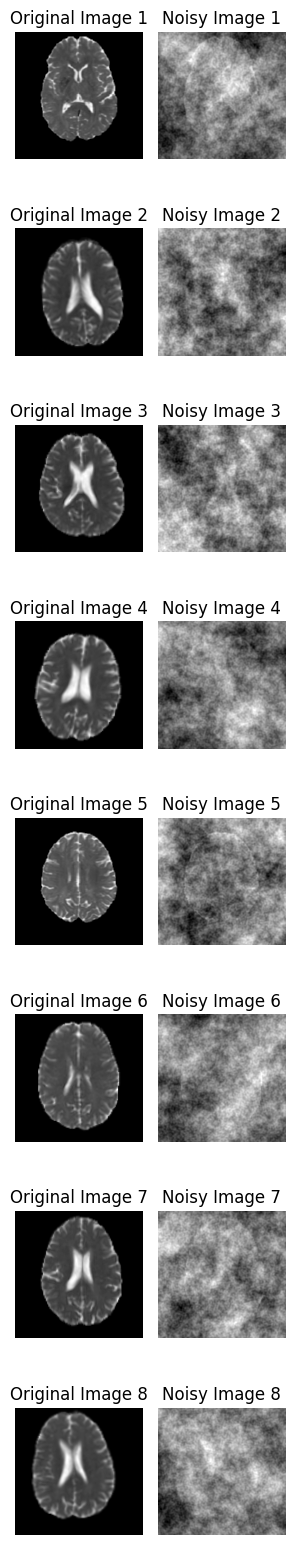

In [23]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(3,2 * 8))

for idx in range(8):  # Iterate through each image in the batch
    original_image = batch[idx, 0].cpu().numpy()

    simplexObj.newSeed()
    # take a slice t from the 3-dimensional noise function as we found that artefacts 
    # were introduced when sampling from the 2-dimensional noise function
    simplex_noise = simplexObj.rand_3d_octaves(shape=(128, 128, 128), octaves=6, persistence=0.8, frequency=64)[12, ...]

    noisy_image = original_image + simplex_noise

    axes[idx, 0].imshow(original_image, cmap="gray")
    axes[idx, 0].set_title(f"Original Image {idx + 1}")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(noisy_image, cmap="gray")
    axes[idx, 1].set_title(f"Noisy Image {idx + 1}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()


### **!! faut utiliser python 3.10+ !!**

In [24]:

def generate_simplex_noise(simplexObj, shape):
    """Generate spatially correlated simplex noise."""

    simplexObj.newSeed()

    if len(shape) ==2:
        # take a slice t from the 3-dimensional noise function as we found that artefacts 
        # were introduced when sampling from the 2-dimensional noise function
        simplex = simplexObj.rand_3d_octaves(shape=(shape[0], shape[0], shape[1]), octaves=6, persistence=0.8, frequency=64)[12,...]
    elif len(shape) == 3:
        simplex = simplexObj.rand_3d_octaves(shape=shape, octaves=6, persistence=0.8, frequency=64)
    elif len(shape) == 4 and shape[1] == 1: # to make it work with shapes of type (batch_size, 1, height, width)
        simplex = simplexObj.rand_3d_octaves(shape=(shape[0], shape[2], shape[3]), octaves=6, persistence=0.8, frequency=64)
        simplex = np.expand_dims(simplex, axis=1)

    return torch.tensor(simplex, dtype=torch.float32)

In [25]:
from monai.utils import StrEnum
from typing import Union

class DDPMPredictionType(StrEnum):
    """
    Set of valid prediction type names for the DDPM scheduler's `prediction_type` argument.

    epsilon: predicting the noise of the diffusion process
    sample: directly predicting the noisy sample
    v_prediction: velocity prediction, see section 2.4 https://imagen.research.google/video/paper.pdf
    """

    EPSILON = "epsilon"
    SAMPLE = "sample"
    V_PREDICTION = "v_prediction"

class SimplexDDPMScheduler(DDPMScheduler):
    def __init__(self, *args, noise_scale=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.noise_scale = noise_scale
        self.simplex_obj = simplex.Simplex_CLASS()
        self.simplex_obj.newSeed()

    #def step(
    #    self, model_output: torch.Tensor, timestep: int, sample: torch.Tensor, generator: torch.Generator | None = None
    #) -> tuple[torch.Tensor, torch.Tensor]:
    def step(
        self, model_output: torch.Tensor, timestep: int, sample: torch.Tensor, generator: Union[torch.Generator, None] = None
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output: direct output from learned diffusion model.
            timestep: current discrete timestep in the diffusion chain.
            sample: current instance of sample being created by diffusion process.
            generator: random number generator.

        Returns:
            pred_prev_sample: Predicted previous sample
        """
        if model_output.shape[1] == sample.shape[1] * 2 and self.variance_type in ["learned", "learned_range"]:
            model_output, predicted_variance = torch.split(model_output, sample.shape[1], dim=1)
        else:
            predicted_variance = None

        # 1. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[timestep - 1] if timestep > 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev

        # 2. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
        if self.prediction_type == DDPMPredictionType.EPSILON:
            pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
        elif self.prediction_type == DDPMPredictionType.SAMPLE:
            pred_original_sample = model_output
        elif self.prediction_type == DDPMPredictionType.V_PREDICTION:
            pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output

        # 3. Clip "predicted x_0"
        if self.clip_sample:
            pred_original_sample = torch.clamp(
                pred_original_sample, self.clip_sample_values[0], self.clip_sample_values[1]
            )

        # 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * self.betas[timestep]) / beta_prod_t
        current_sample_coeff = self.alphas[timestep] ** (0.5) * beta_prod_t_prev / beta_prod_t

        # 5. Compute predicted previous sample µ_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample

        # 6. Add noise
        variance: torch.Tensor = torch.tensor(0)
        if timestep > 0:
            self.simplex_obj.newSeed()
            noise = generate_simplex_noise(self.simplex_obj, shape=model_output.size()).to(model_output.device)
            
            """ #TODO
            noise = torch.randn(
                model_output.size(),
                dtype=model_output.dtype,
                layout=model_output.layout,
                generator=generator,
                device=model_output.device,
            )"""
            variance = (self._get_variance(timestep, predicted_variance=predicted_variance) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample, pred_original_sample

In [26]:
device = torch.device(DEVICE_TYPE)
simplexObj = simplex.Simplex_CLASS()


model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=(0, 128, 128),
)
model.to(device)

num_train_timesteps = 1000
scheduler = SimplexDDPMScheduler(num_train_timesteps=num_train_timesteps)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

Faut remplacer DDPMSchedule.step()

dans https://github.com/Project-MONAI/MONAI/blob/1.5.0/monai/networks/schedulers/ddpm.py#L68-L254

ligne 243

### Model training

Epoch 2: 100%|███████████| 50/50 [00:27<00:00,  1.79it/s, loss=0.0233]


saved new best metric model
current epoch: 3 current val loss: 0.1294
best val loss: 0.1294 at epoch: 3


Epoch 5: 100%|███████████| 50/50 [00:29<00:00,  1.68it/s, loss=0.0175]


saved new best metric model
current epoch: 6 current val loss: 0.1232
best val loss: 0.1232 at epoch: 6


Epoch 8: 100%|████████████| 50/50 [00:27<00:00,  1.84it/s, loss=0.012]


saved new best metric model
current epoch: 9 current val loss: 0.0781
best val loss: 0.0781 at epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.02it/s]


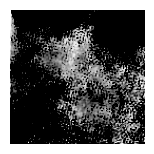

Epoch 14: 100%|█████████| 50/50 [00:27<00:00,  1.83it/s, loss=0.00838]


saved new best metric model
current epoch: 15 current val loss: 0.0472
best val loss: 0.0472 at epoch: 15


Epoch 20: 100%|█████████| 50/50 [00:27<00:00,  1.80it/s, loss=0.00745]


saved new best metric model
current epoch: 21 current val loss: 0.0450
best val loss: 0.0450 at epoch: 21


Epoch 23: 100%|█████████| 50/50 [00:26<00:00,  1.86it/s, loss=0.00664]


saved new best metric model
current epoch: 24 current val loss: 0.0434
best val loss: 0.0434 at epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.24it/s]


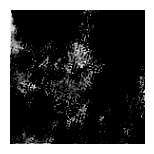

Epoch 26: 100%|███████████| 50/50 [00:27<00:00,  1.81it/s, loss=0.006]


saved new best metric model
current epoch: 27 current val loss: 0.0286
best val loss: 0.0286 at epoch: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.65it/s]


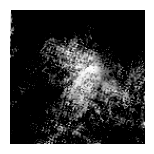

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.42it/s]


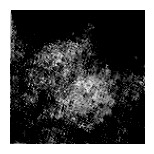

Epoch 53: 100%|█████████| 50/50 [00:28<00:00,  1.73it/s, loss=0.00554]


saved new best metric model
current epoch: 54 current val loss: 0.0228
best val loss: 0.0228 at epoch: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.25it/s]


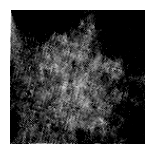

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.26it/s]


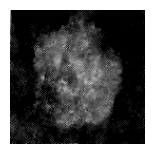

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.12it/s]


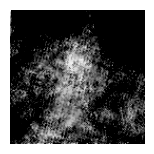

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.20it/s]


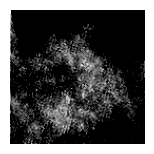

Epoch 101: 100%|████████| 50/50 [00:28<00:00,  1.73it/s, loss=0.00356]


saved new best metric model
current epoch: 102 current val loss: 0.0205
best val loss: 0.0205 at epoch: 102


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.00it/s]


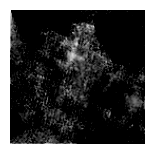

Epoch 110: 100%|█████████| 50/50 [00:28<00:00,  1.78it/s, loss=0.0037]


saved new best metric model
current epoch: 111 current val loss: 0.0187
best val loss: 0.0187 at epoch: 111


Epoch 119: 100%|████████| 50/50 [00:27<00:00,  1.83it/s, loss=0.00379]


saved new best metric model
current epoch: 120 current val loss: 0.0187
best val loss: 0.0187 at epoch: 120


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.00it/s]


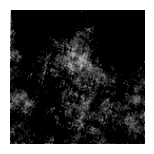

Epoch 128: 100%|████████| 50/50 [00:26<00:00,  1.87it/s, loss=0.00262]


saved new best metric model
current epoch: 129 current val loss: 0.0169
best val loss: 0.0169 at epoch: 129


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.14it/s]


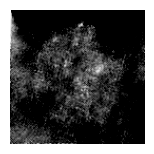

Epoch 140: 100%|████████| 50/50 [00:27<00:00,  1.85it/s, loss=0.00279]


saved new best metric model
current epoch: 141 current val loss: 0.0142
best val loss: 0.0142 at epoch: 141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.68it/s]


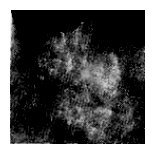

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.54it/s]


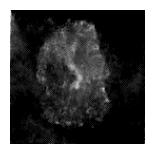

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.55it/s]


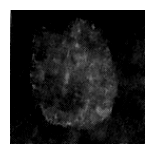

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.69it/s]


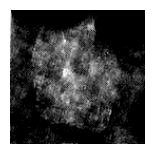

Epoch 188: 100%|████████| 50/50 [00:26<00:00,  1.88it/s, loss=0.00266]


saved new best metric model
current epoch: 189 current val loss: 0.0130
best val loss: 0.0130 at epoch: 189


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.42it/s]


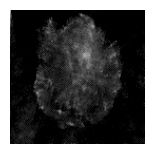

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.17it/s]


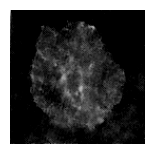

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.95it/s]


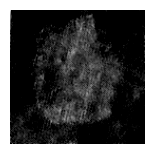

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.88it/s]


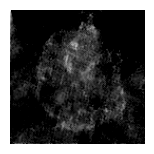

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.50it/s]


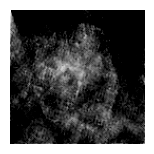

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.81it/s]


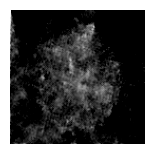

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.41it/s]


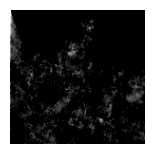

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.72it/s]


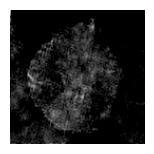

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.29it/s]


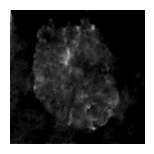

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.39it/s]


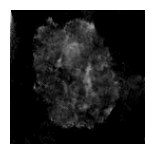

Epoch 302: 100%|████████| 50/50 [00:28<00:00,  1.78it/s, loss=0.00229]


saved new best metric model
current epoch: 303 current val loss: 0.0122
best val loss: 0.0122 at epoch: 303


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.36it/s]


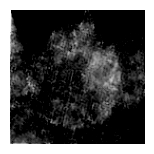

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.57it/s]


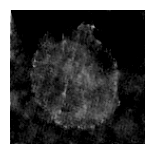

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.93it/s]


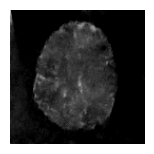

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.34it/s]


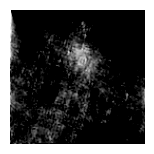

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.77it/s]


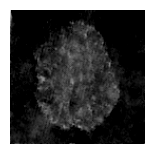

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.91it/s]


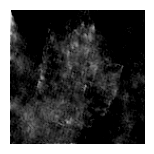

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.20it/s]


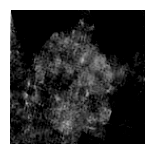

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.65it/s]


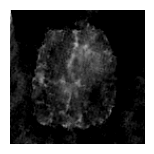

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.63it/s]


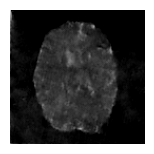

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.44it/s]


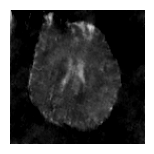

Epoch 422: 100%|████████| 50/50 [00:28<00:00,  1.76it/s, loss=0.00232]


saved new best metric model
current epoch: 423 current val loss: 0.0104
best val loss: 0.0104 at epoch: 423


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.77it/s]


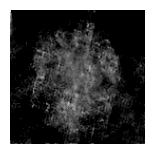

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.07it/s]


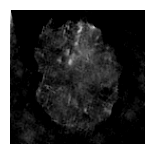

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.51it/s]


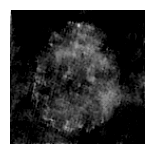

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.24it/s]


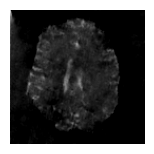

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.25it/s]


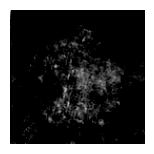

Epoch 488: 100%|████████| 50/50 [00:27<00:00,  1.81it/s, loss=0.00234]


saved new best metric model
current epoch: 489 current val loss: 0.0090
best val loss: 0.0090 at epoch: 489


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.27it/s]


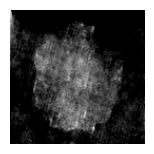

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.41it/s]


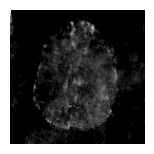

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.19it/s]


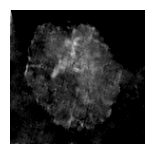

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.13it/s]


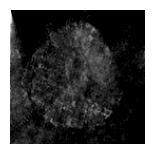

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.12it/s]


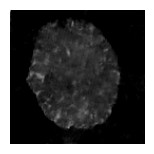

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.97it/s]


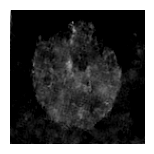

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.99it/s]


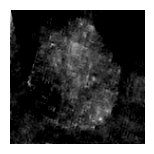

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.89it/s]


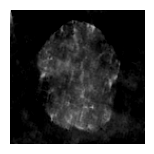

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.65it/s]


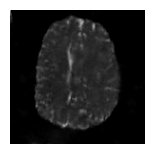

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.49it/s]


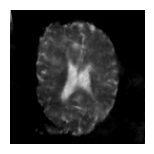

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.57it/s]


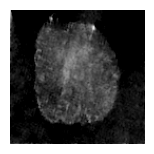

Epoch 620: 100%|████████| 50/50 [00:27<00:00,  1.84it/s, loss=0.00214]


saved new best metric model
current epoch: 621 current val loss: 0.0090
best val loss: 0.0090 at epoch: 621


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.25it/s]


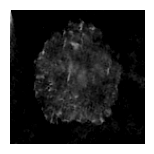

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.19it/s]


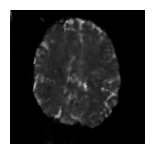

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.51it/s]


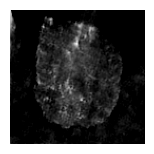

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.05it/s]


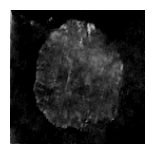

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.69it/s]


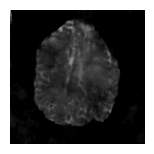

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.72it/s]


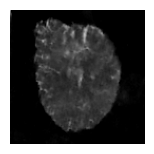

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.43it/s]


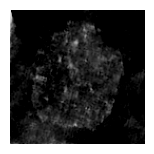

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.90it/s]


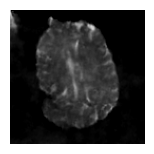

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.04it/s]


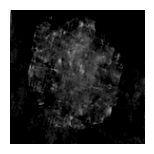

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.39it/s]


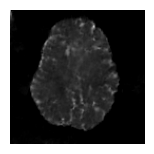

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.80it/s]


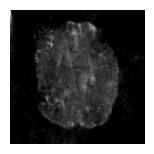

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.41it/s]


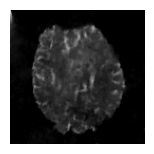

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.76it/s]


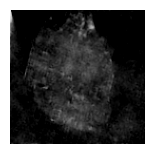

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.28it/s]


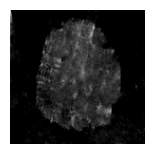

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.79it/s]


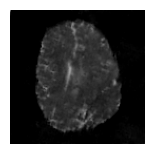

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.20it/s]


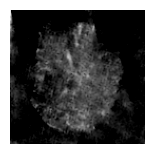

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.94it/s]


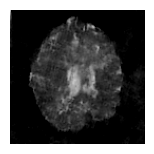

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.51it/s]


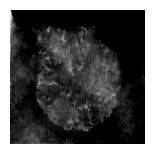

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.74it/s]


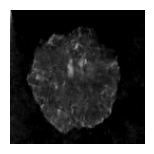

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.82it/s]


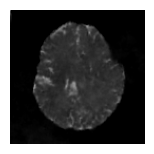

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.19it/s]


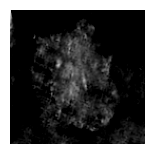

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.21it/s]


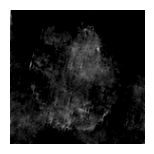

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.12it/s]


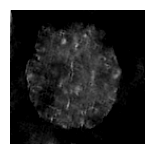

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.13it/s]


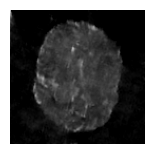

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.16it/s]


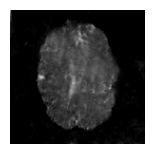

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.62it/s]


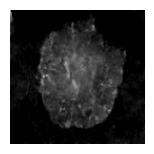

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.66it/s]


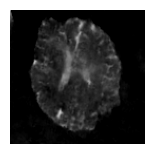

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.33it/s]


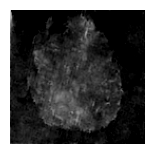

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.88it/s]


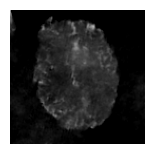

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.16it/s]


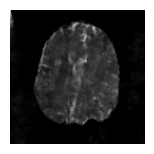

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.61it/s]


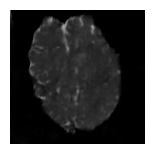

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.01it/s]


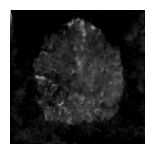

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.17it/s]


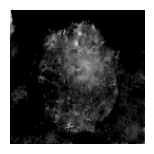

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.15it/s]


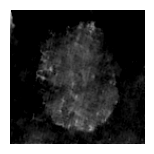

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.13it/s]


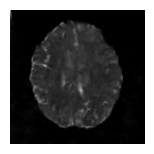

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.56it/s]


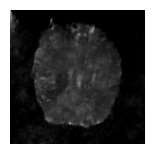

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.54it/s]


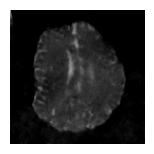

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.04it/s]


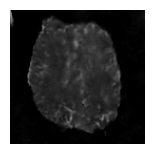

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.06it/s]


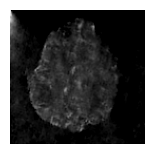

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.06it/s]


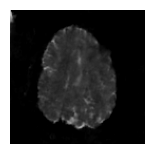

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.30it/s]


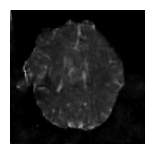

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.95it/s]


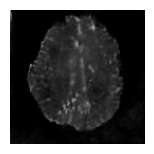

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.13it/s]


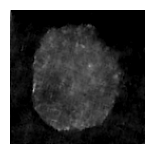

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.40it/s]


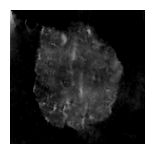

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.34it/s]


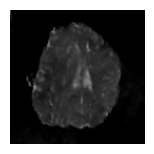

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.48it/s]


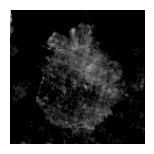

Epoch 1175: 100%|███████| 50/50 [00:28<00:00,  1.74it/s, loss=0.00193]


saved new best metric model
current epoch: 1176 current val loss: 0.0088
best val loss: 0.0088 at epoch: 1176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.97it/s]


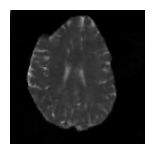

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.25it/s]


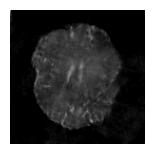

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.81it/s]


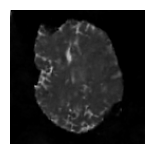

Epoch 1205: 100%|███████| 50/50 [00:28<00:00,  1.73it/s, loss=0.00197]


saved new best metric model
current epoch: 1206 current val loss: 0.0083
best val loss: 0.0083 at epoch: 1206


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.70it/s]


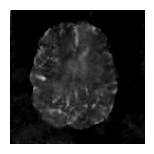

Epoch 1223: 100%|███████| 50/50 [00:28<00:00,  1.76it/s, loss=0.00169]


saved new best metric model
current epoch: 1224 current val loss: 0.0077
best val loss: 0.0077 at epoch: 1224


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.75it/s]


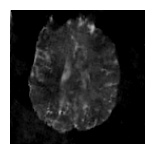

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.32it/s]


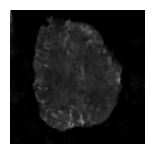

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.94it/s]


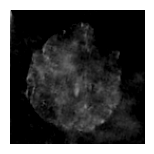

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.14it/s]


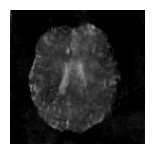

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.30it/s]


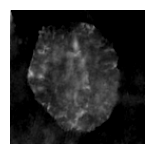

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.62it/s]


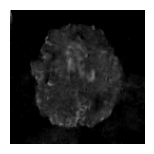

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.23it/s]


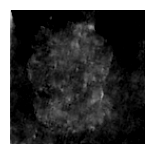

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.06it/s]


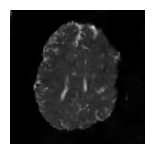

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.48it/s]


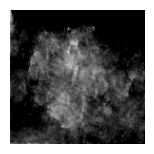

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.75it/s]


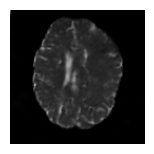

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.89it/s]


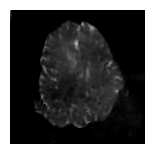

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.66it/s]


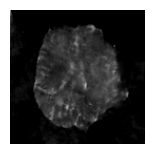

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.14it/s]


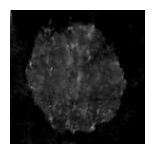

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.47it/s]


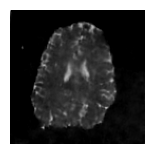

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.24it/s]


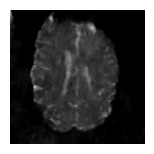

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.88it/s]


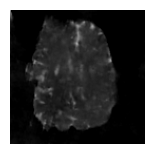

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.88it/s]


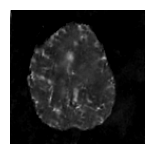

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.06it/s]


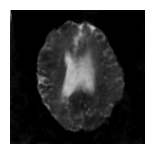

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.58it/s]


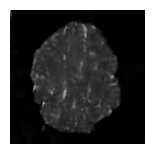

Epoch 1443:  82%|█████▋ | 41/50 [00:24<00:06,  1.50it/s, loss=0.00192]

In [ ]:

def train_epoch(epoch, best_val_epoch_loss, best_val_epoch):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type=DEVICE_TYPE, enabled=True):
            # Generate random noise
            #noise = torch.randn_like(images).to(device)
            noise = generate_simplex_noise(simplexObj, images.shape).to(device)

            # Create timesteps
            timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        epoch_len = len(train_ds)
        

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})

    epoch_loss_list.append(epoch_loss / (step + 1))
    writer.add_scalar("train_loss", epoch_loss / (step + 1), epoch)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch.to(device)
            with torch.no_grad(), autocast(device_type=DEVICE_TYPE, enabled=True):
                noise = generate_simplex_noise(simplexObj, shape=images.shape).to(device)

                timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()

            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})

        val_epoch_loss_list.append(val_epoch_loss / (step + 1))
        writer.add_scalar("val_loss", val_epoch_loss / (step + 1), epoch)   # moi

        if val_epoch_loss < best_val_epoch_loss:
            best_val_epoch_loss = val_epoch_loss
            best_val_epoch = epoch + 1
            torch.save(
                model.state_dict(),
                os.path.join(ROOT_DIR+"Code/Best_models/2d_ddpm_tutorial", "Experiment_3-1_ADC_2d_ddpm_simplex_noise_best_metric_model_dallas_and_hcp_ya.pth"),
            )
            print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current val loss: {val_epoch_loss:.4f}"
                f"\nbest val loss: {best_val_epoch_loss:.4f}"
                f" at epoch: {best_val_epoch}"
            )
            writer.add_scalar("best_val_loss", best_val_epoch_loss, best_val_epoch)

            noise = generate_simplex_noise(simplexObj, shape=(1,1,IMAGE_SIZE, IMAGE_SIZE)).to(device)
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(device_type=DEVICE_TYPE, enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
            writer.add_image("sampled_image", image[0, 0].cpu().numpy(), global_step=epoch, dataformats="HW")
            #plt.figure(figsize=(2, 2))
            #plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            #plt.tight_layout()
            #plt.axis("off")
            #plt.show()

RESUME_TRAINING = True

if RESUME_TRAINING == False:
    print("STARTING NEW TRAINING")
    writer = SummaryWriter(ROOT_DIR+"Code/Tensorboard/Experiment_3-1_ADC_2d_ddpm_simplex_noise")

    max_epochs = 6000
    val_interval = 3
    epoch_loss_list = []
    val_epoch_loss_list = []

    best_val_epoch_loss = np.inf
    best_val_epoch = 0

    scaler = GradScaler(DEVICE_TYPE)
    total_start = time.time()


    for epoch in range(max_epochs, best_val_epoch_loss, best_val_epoch):
        train_epoch(epoch)

else:
    
    last_epoch = 1442
    print("RESUMING TRAINING from epoch {last_epoch}")
    writer = SummaryWriter(ROOT_DIR+"Code/Tensorboard/Experiment_3-1_ADC_2d_ddpm_simplex_noise")

    max_epochs = 6000
    val_interval = 3
    epoch_loss_list = []
    val_epoch_loss_list = []

    best_val_epoch_loss = 0.007703
    best_val_epoch = 1224

    scaler = GradScaler(DEVICE_TYPE)
    total_start = time.time()

    model.load_state_dict(torch.load(os.path.join(ROOT_DIR+"Code/Best_models/2d_ddpm_tutorial", "Experiment_3-1_ADC_2d_ddpm_simplex_noise_best_metric_model_dallas_and_hcp_ya.pth"), map_location=DEVICE_TYPE))

    for epoch in range(last_epoch,max_epochs):
        train_epoch(epoch, best_val_epoch_loss, best_val_epoch)




total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")